# Introducing Tensorflow

Be sure to "pip install tensorflow" or "pip install tensorflow-gpu" first!

## The world's simplest Tensorflow application

Let's begin by writing a really simple program to illustrate Tensorflow's main concepts. We'll set up two Variables, named "a" and "b", which each contain a tensor which contains a single value - the number 1, and the number 2.

We then create a graph "f" that adds these two tensors together. But "f = a + b" just creates the graph; it doesn't actually perform the addition yet.

Next we need to initialize any global variables before we run the graph.

And finally, we create a Tensorflow Session object, run our variable initializer, and execute the graph with eval(). 

This returns the sum of 1 + 2 in a rather complex, yet highly scalable manner :)

In [1]:
import tensorflow as tf

a = tf.Variable(1, name="a")
b = tf.Variable(2, name="b")
f = a + b

init = tf.global_variables_initializer()
with tf.Session() as s:
    init.run()
    print( f.eval() )

3


## And now for something more interesting: Handwriting recognition

The standard example for machine learning these days is the MNIST data set, a collection of 70,000 handwriting samples of the numbers 0-9. Our challenge - to predict which number each handwritten image represents.

Although we'll talk about neural networks that are specifically well suited for image recognition later, we actually don't need to go there for this relatively simple task. We can achieve decent without a whole lot of code.

Each image is 28x28 grayscale pixels, so we can treat each image as just a 1D array, or tensor, of 768 numbers. As long as we're consistent in how we flatten each image into an array, it'll still work. Yes, it would be even better if we could preserve the 2D structure of the data while training - but we'll get there later.

Let's start by importing the data set, which conveniently is part of tensorflow itself:

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

sess = tf.InteractiveSession()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

MNIST provides 55,000 samples in a training data set, 10,000 samples in a test data set, and 5,000 samples in a "validation" data set. We haven't talked about validation sets before, but their intent is to be used for model selection. So you'd use validation data to select your model, train the model with the training set, and then evaluate the model using the test data set.

If you're new to the concept of train/test - it's important to evaluate the performance of our neural network using data it's never seen before. Otherwise it's kinda like giving students a math test for problems they already have the answers for. So, we use a completely different set of images to train our neural network from the images used for testing its accuracy.

The training data is therefore a tensor of shape [55,000, 784] - 55,000 instances of 784 numbers that represent each image.

The test data is encoded as "one_hot" when we loaded it above. Think of one_hot as a binary representation of the label data - that is, which number each handwriting sample was intended to represent. Mathematically one_hot represents a dimension for every possible label value. Every dimension is set to the value 0, except for the "correct" one which is set to 1. For example, the label vector representing the number 1 would be [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] (remember we start counting at 0.) It's just a format that's optimized for how the labels are applied during training.

So the test data is a tensor of shape [55,000, 10] - 55,000 test images each associated with 10 binary values that indicate whether or not the image represents a given number from 0-9.

Let's define a little function to let us visualize what the input data looks like, and pick some random training image to see what it is we're up against:


[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


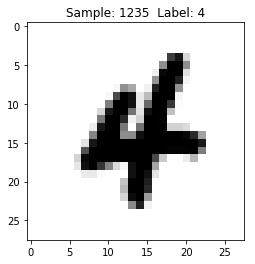

In [4]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(mnist.train.labels[num])  
    #Print the label converted back to a number
    label = mnist.train.labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = mnist.train.images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1235)

So, you can see the "one_hot" representation of the number this image represents in the array that was printed out from the training label for image# 1234, as well as what this particular sample looks like. You can tell that some of the training data would even be challenging for a human to classify!

Go ahead and try different input images to get a feel of the data we're given. Any value between 0 and 55,000 will work.

As a reminder, we're flattening each image to a 1D array of 784 (28 x 28) numerical values. Each one of those values will be an input node into our deep neural network. Let's visualize how the data is being fed into it just to drive that point home:

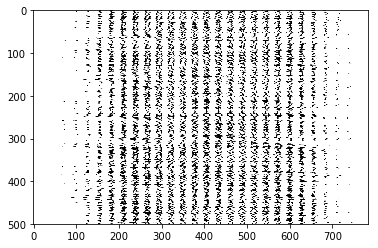

In [5]:
import numpy as np

images = mnist.train.images[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, mnist.train.images[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

This is showing the first 500 training samples, one on each row. Imagine each pixel on each row getting fed into the bottom layer of a neural network 768 neurons (or "units") wide as we train our neural network.

So let's start setting up that artificial neural network. We'll start by creating "placeholders" for the input images and for the "correct" labels for each. Think of these as parameters - we build up our neural network model without knowledge of the actual data that will be fed into it; we just need to construct it in such a way that our data will fit in.

So our "input_images" placeholder will be set up to hold an array of values that consist of 784 floats (28x28), and our "target_labels" placeholder will be set up to hold an array of values that consist of 10 floats (one-hot format for 10 digits.)

While training, we'll assign input_images to the training images and target_labels to the training lables. While testing, we'll use the test images and test labels instead.

In [6]:
input_images = tf.placeholder(tf.float32, shape=[None, 784])
target_labels = tf.placeholder(tf.float32, shape=[None, 10])

So let's set up our deep neural network. We'll need an input layer with one node per input pixel per image, or 784 nodes. That will feed into a hidden layer of some arbitrary size - let's pick 512. That hidden layer will output 10 values, corresonding to scores for each classification to be fed into softmax.

We'll need to reserve variables to keep track of the all the weights and biases for both layers:

In [14]:
hidden_nodes = 1024

input_weights = tf.Variable(tf.truncated_normal([784, hidden_nodes]))
input_biases = tf.Variable(tf.zeros([hidden_nodes]))

hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes, 10]))
hidden_biases = tf.Variable(tf.zeros([10]))

Now let's set up the neural network itself. We'll define the input layer and associate it with our placeholder for input data. All this layer does is multiply these inputs by our input_weight tensor which will be learned over time.

Then we'll feed that into our hidden layer, which applies the ReLU activation function to the weighted inputs with our learned biases added in as well.

Finally our output layer, called digit_weights, multiplies in the learned weights of the hidden layer and adds in the hidden layer's bias term.

In [15]:
input_layer = tf.matmul(input_images, input_weights)
hidden_layer = tf.nn.relu(input_layer + input_biases)
digit_weights = tf.matmul(hidden_layer, hidden_weights) + hidden_biases

Make sure you noodle on the above block. This sets up a deep neural network like the one we talked about in our slides.

output layer

hidden layer

input layer

Next we will define our loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. Remember digit_weights is the output of our final layer, and we're comparing that against the target labels used for training.

In [16]:
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=digit_weights, labels=target_labels))

Now we will set up our gradient descent optimizer, initializing it with an aggressive learning rate (0.5) and our loss function defined above.

That learning rate is an example of a hyperparameter that may be worth experimenting with and tuning.

In [17]:
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

Next we'll want to train our neural network and measure its accuracy. First let's define some methods for measuring the accuracy of our trained model. 

correct_prediction will look at the output of our neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given. During testing, digit_weights will be our prediction based on the test data we give the network, and target_labels is a placeholder that we will assign to our test labels. Ultimately this gives us a 1 for every correct classification, and a 0 for every incorrect classification.

"accuracy" then takes the average of all the classifications to produce an overall score for our model's accuracy.

In [18]:
correct_prediction = tf.equal(tf.argmax(digit_weights,1), tf.argmax(target_labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Let's train this thing and see how it works! 

We'll set up a Tensorflow session, and initialize our variables. Next we will train our network in 2000 steps (or "epochs") with batches of 100 samples from our training data. At each step, we assign the input_images placeholder to the current batch of training images, and the target_labels placeholder to the current batch of training labels.

Once training is complete, we'll measure the accuracy of our model using the accuracy graph we defined above. While measuring accuracy, we assign the input_images placeholder to our test images, and the target_labels placeholder to our test labels.

In [20]:
tf.global_variables_initializer().run()

for x in range(2000):
    batch = mnist.train.next_batch(200)
    optimizer.run(feed_dict={input_images: batch[0], target_labels: batch[1]})
    if ((x+1) % 200 == 0):
        print("Training epoch " + str(x+1))
        print("Accuracy: " + str(accuracy.eval(feed_dict={input_images: mnist.test.images, target_labels: mnist.test.labels})))

Training epoch 200
Accuracy: 0.912
Training epoch 400
Accuracy: 0.9222
Training epoch 600
Accuracy: 0.9275
Training epoch 800
Accuracy: 0.9339
Training epoch 1000
Accuracy: 0.9327
Training epoch 1200
Accuracy: 0.9357
Training epoch 1400
Accuracy: 0.9388
Training epoch 1600
Accuracy: 0.9401
Training epoch 1800
Accuracy: 0.9394
Training epoch 2000
Accuracy: 0.9403


You should have about 92% accuracy. Not bad! But hey, we're just starting.

Let's take a look at some of the misclassified images and see just how good or bad our model is, compared to what your own brain can do. We'll go through the first 100 test images and look at the ones that are misclassified:

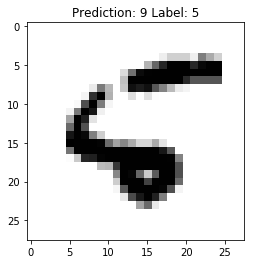

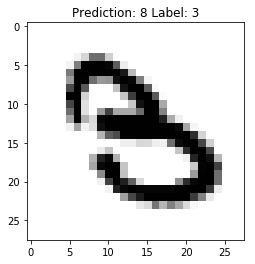

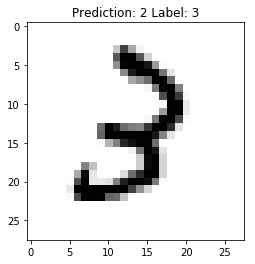

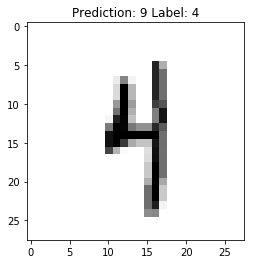

In [21]:
for x in range(100):
    # Load a single test image and its label
    x_train = mnist.test.images[x,:].reshape(1,784)
    y_train = mnist.test.labels[x,:]
    # Convert the one-hot label to an integer
    label = y_train.argmax()
    # Get the classification from our neural network's digit_weights final layer, and convert it to an integer
    prediction = sess.run(digit_weights, feed_dict={input_images: x_train}).argmax()
    # If the prediction does not match the correct label, display it
    if (prediction != label) :
        plt.title('Prediction: %d Label: %d' % (prediction, label))
        plt.imshow(x_train.reshape([28,28]), cmap=plt.get_cmap('gray_r'))
        plt.show()

To be honest, I'd be a little unsure about some of those myself!

## Exercise

See if you can improve upon the accuracy. Try using more hidden neurons (nodes). Try using fewer! Try a different learning rate. Try adding another hidden layer. Try different batch sizes. What's the best accuracy you can get from this multi-layer perceptron?